In [17]:
import requests
import json
import numpy as np
import pandas as pd

# API Endpoints (Replace with actual URLs if needed)
CURRENT_QUIZ_API = "https://www.jsonkeeper.com/b/LLQT"
HISTORICAL_QUIZ_API = "https://api.jsonserve.com/XgAgFJ"



In [18]:
# Fetch Data
def fetch_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data from {url}")
        return None



In [19]:

# Load Data
current_quiz_data = fetch_data(CURRENT_QUIZ_API)
historical_quiz_data = fetch_data(HISTORICAL_QUIZ_API)


# Process and Analyze Data
def analyze_student_performance(current_data, historical_data):
    performance_summary = {}

    if isinstance(historical_data, list):  # Check if data is a list
        for entry in historical_data:
            user_id = entry.get('user_id', 'Unknown')
            quizzes = entry.get('quizzes', [])  # Extract quiz data

            total_attempts = len(quizzes)
            total_correct = sum([q.get('correct_answers', 0) for q in quizzes])
            total_questions = sum([q.get('total_questions', 0) for q in quizzes])

            accuracy = (total_correct / total_questions) * 100 if total_questions else 0
            weak_topics = [q.get('weak_topics', []) for q in quizzes]

            performance_summary[user_id] = {
                'total_attempts': total_attempts,
                'accuracy': accuracy,
                'weak_topics': list(set(sum(weak_topics, [])))  # Flatten list of weak topics
            }

    return performance_summary


In [20]:
# Generate Recommendations
def generate_recommendations(performance_data):
    recommendations = {}

    for user, data in performance_data.items():
        if data['accuracy'] < 50:
            focus_topics = data['weak_topics'] if data['weak_topics'] else ["General Practice"]
            recommendations[user] = {
                'message': "Improve accuracy! Focus on these topics:",
                'topics': focus_topics
            }
        else:
            recommendations[user] = {
                'message': "Good job! Keep practicing to maintain consistency.",
                'topics': []
            }

    return recommendations



In [21]:

from sklearn.linear_model import LinearRegression

# Predict NEET Rank
def predict_neet_rank(performance_data):
    user_ids = list(performance_data.keys())
    accuracies = np.array([performance_data[user]['accuracy'] for user in user_ids]).reshape(-1, 1)
    ranks = np.array([1000 - (performance_data[user]['accuracy'] * 10) for user in user_ids])  # Dummy rank formula

    model = LinearRegression()
    model.fit(accuracies, ranks)
    predicted_ranks = model.predict(accuracies)

    rank_predictions = {user: int(rank) for user, rank in zip(user_ids, predicted_ranks)}
    return rank_predictions



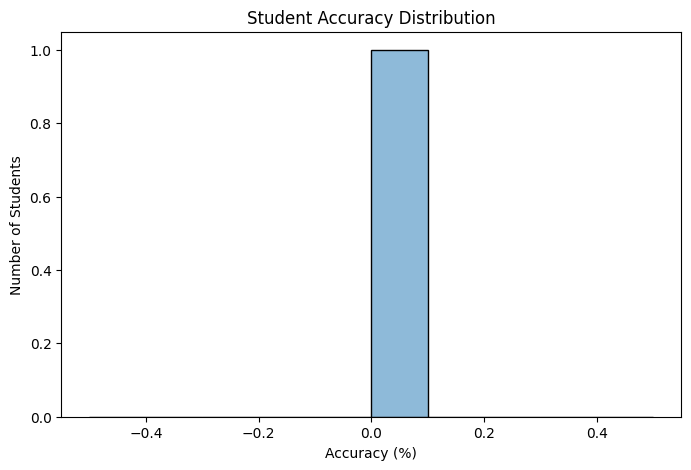

No weak topics data available to plot.


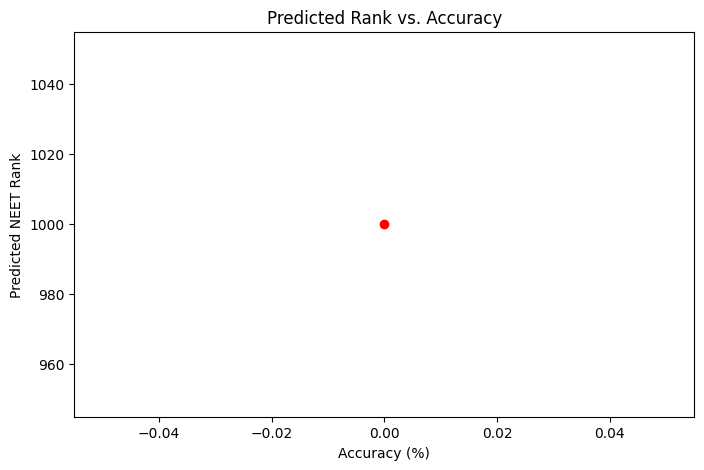

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming performance_data is available
accuracies = [data['accuracy'] for data in performance_data.values()]
all_weak_topics = sum([data['weak_topics'] for data in performance_data.values()], [])

# 1. Accuracy Distribution
plt.figure(figsize=(8, 5))
sns.histplot(accuracies, bins=10, kde=True)
plt.xlabel("Accuracy (%)")
plt.ylabel("Number of Students")
plt.title("Student Accuracy Distribution")
plt.show()  # Ensure the graph appears

# 2. Weak Topics (Check if there are any weak topics)
if all_weak_topics:
    topic_counts = pd.Series(all_weak_topics).value_counts()
    plt.figure(figsize=(8, 5))
    topic_counts.plot(kind='bar', color='skyblue')
    plt.xlabel("Topics")
    plt.ylabel("Frequency")
    plt.title("Most Common Weak Topics")
    plt.xticks(rotation=45)
    plt.show()  # Ensure the graph appears
else:
    print("No weak topics data available to plot.")

# 3. Rank Prediction Scatter Plot
predicted_ranks = predict_neet_rank(performance_data)
sorted_users = sorted(performance_data.keys(), key=lambda user: performance_data[user]['accuracy'])
sorted_accuracies = [performance_data[user]['accuracy'] for user in sorted_users]
sorted_ranks = [predicted_ranks[user] for user in sorted_users]

plt.figure(figsize=(8, 5))
plt.scatter(sorted_accuracies, sorted_ranks, color='red')
plt.xlabel("Accuracy (%)")
plt.ylabel("Predicted NEET Rank")
plt.title("Predicted Rank vs. Accuracy")
plt.show()  # Ensure the graph appears


In [23]:
# Execution
performance_data = analyze_student_performance(current_quiz_data, historical_quiz_data)
recommendations = generate_recommendations(performance_data)
neet_rank_predictions = predict_neet_rank(performance_data)

# Output Results
print(json.dumps(recommendations, indent=2))
print(json.dumps(neet_rank_predictions, indent=2))

{
  "YcDFSO4ZukTJnnFMgRNVwZTE4j42": {
    "message": "Improve accuracy! Focus on these topics:",
    "topics": [
      "General Practice"
    ]
  }
}
{
  "YcDFSO4ZukTJnnFMgRNVwZTE4j42": 1000
}
